Competition Link : https://www.kaggle.com/t/f7a909a19bde4d5aaa754d107e97e92d

## Arabic Tweets Multi-Class Classification Problem

#### This notebook outlines the process of building, training, and evaluating a model for the Kaggle competition on Arabic Tweet Sentiment Classification. The primary goal is to classify tweets into four sentiment categories: Objective (OBJ), Negative (NEG), Neutral (NEUTRAL), and Positive (POS).

### Importing Libraries

In [ ]:
import os
import re
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from arabic_reshaper import reshape
from deep_translator import GoogleTranslator
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    AutoModelForSeq2SeqLM, 
    Trainer, 
    TrainingArguments
)

## 1. Perform Data cleaning and Preprocessing

###  Loading and Exploring the Dataset

In [2]:
df = pd.read_csv("train_data.csv")
df.head()

,Tweet_ID,Tweet,Label
0,1,#الرياض #أمطار_الرياض #السعودية #مطر #الرياض_ت...,OBJ
1,2,من بين الأسماء محمود القرش، مصر الجديدة وآخرين...,OBJ
2,3,مقتل طفلة لبنانية في تبادل إطلاق نار بين علويي...,OBJ
3,4,#الروح_و_الجسد #مصطفي_محمود,OBJ
4,5,دعبد المنعم أبو الفتوح فى عيون العالم,OBJ


In [3]:
df.Label.value_counts()

Label
OBJ        5233
NEG        1317
NEUTRAL     654
POS         627
Name: count, dtype: int64

In [6]:
df[df["Tweet"].apply(lambda x: bool(re.search(r"[:'-]\)", x)))].head(30)

,Tweet_ID,Tweet,Label
66,67,مع كل اللى بنشوفه كل شئء جائز :)),OBJ
97,98,استعدوا لاتنين ريتويت حالا بس ما تعلقوش الا لم...,OBJ
185,186,بكرة أحلي بإذن الله:),OBJ
194,195,وحدوا الله يا جماعة وبلاش إشاعات عن مفاجآت عشا...,POS
243,244,خرجت النهارده لقيت كل الشوارع وكل الحيطان عليه...,NEG
254,255,صح :),POS
275,276,طنش وحط راسك ع مخدتك ونام اكسب صحتك وراحة بالك...,OBJ
301,302,إن شاءالله الزمالك بطل الدورى 2013/3014 وافتكر...,OBJ
341,342,انا لو خلفت ولد هسمية #عبد #الفتاح :) اهو لو م...,OBJ
437,438,حجز تي شيرت #أولتراس_أهلاوي في #كفرالزيات #07 ...,OBJ


In [7]:
df.iloc[1072]

Tweet_ID                                                 1073
Tweet       احداث العمرانية وصمة على جبين كل مصرىالدين لله...
Label                                                     NEG
Name: 1072, dtype: object

#### Cleaning process
#### Handling Emoticons and Emojis
- Detecting Emoticons
- Converting Emoticons to Words
- Converting Unicode Emojis to Words
#### Text Cleaning
#####  Cleaning Functions
- Removing URLs
- Handling Hashtags
- Converting Emoticons and Emojis
- Normalizing Arabic Text

In [ ]:
# Emoticons
def convert_emoticons(text):
   
    with open("emoticons.json", "r", encoding="utf-8") as f:
        emotions = json.load(f)
    
    for emoticon, emotion in emotions.items():
        if re.search(re.escape(emoticon), text):
            text = re.sub(re.escape(emoticon), '', text).strip() + " " + emotion
    return text

# Unicode Emojis
def convert_emojis(text):
    with open("emo_unicode.txt", "r", encoding="utf-8") as file:
        EMO_UNICODE = json.load(file)
    
    UNICODE_EMO = {v: k for k, v in EMO_UNICODE.items()}
    
    for emot in UNICODE_EMO:
        text = re.sub(
            r'(' + re.escape(emot) + ')', 
            " ".join(UNICODE_EMO[emot].replace(",", "").replace(":", "").split()),
            text
        )
    return text

def convert_to_arabic_numerals(text):
    eng_to_arabic = {
        '0': '٠', '1': '١', '2': '٢', '3': '٣', '4': '٤',
        '5': '٥', '6': '٦', '7': '٧', '8': '٨', '9': '٩'
    }
    text = ''.join(eng_to_arabic.get(ch, ch) for ch in text)
    return text


def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"#(\w+)", lambda match: match.group(1).replace("_", " "), text)
    text = convert_emojis(text)
    text = convert_emoticons(text)
    text = convert_to_arabic_numerals(text)
    text = re.sub(r"[^\w\s]", "", text)  
    text = re.sub(r"[إأآا]", "ا", text)
    text = re.sub(r"ى", "ي", text)
    text = re.sub(r"ة", "ه", text)
    text = re.sub(r"[ًٌٍَُِّْ]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = text.replace("_", " ").strip()
    return text

In [ ]:
df["Cleaned_Tweet"] = df["Tweet"].apply(clean_text)

In [ ]:
df[["Tweet","Cleaned_Tweet"]].head()

In [ ]:
df[df["Cleaned_Tweet"].apply(lambda x: bool(re.search(r"_", x)))]

In [ ]:
df["Cleaned_Tweet"].iloc[911]

- Due to the conversion of emojis to text, the result is in English, but it needs to be in Arabic. This function accomplishes that

In [ ]:
# Function to translate English words  from emotions covertor in a sentence to Arabic
def translate_english_to_arabic(text):
    words = text.split()
    translated_sentence = []

    for word in words:
        if any('A' <= char <= 'z' for char in word):
            try:
                translated_word = GoogleTranslator(source='en', target='ar').translate(word)
                translated_word = translated_word if translated_word else word
                translated_sentence.append(translated_word)
            except Exception as e:
                print(f"Error translating word '{word}': {e}")
                translated_sentence.append(word)  
        else:
            translated_sentence.append(word)
    return ' '.join(translated_sentence)

In [ ]:
df["Translated_Cleaned_Tweet"] = df["Cleaned_Tweet"].apply(translate_english_to_arabic)

In [9]:
df[["Cleaned_Tweet","Translated_Cleaned_Tweet"]].head(10)

,Cleaned_Tweet,Translated_Cleaned_Tweet
0,الرياض امطار الرياض السعوديه مطر الرياض تغرق ا...,الرياض امطار الرياض السعوديه مطر الرياض تغرق ا...
1,من بين الاسماء محمود القرش مصر الجديده واخرين ...,من بين الاسماء محمود القرش مصر الجديده واخرين ...
2,مقتل طفله لبنانيه في تبادل اطلاق نار بين علويي...,مقتل طفله لبنانيه في تبادل اطلاق نار بين علويي...
3,الروح و الجسد مصطفي محمود,الروح و الجسد مصطفي محمود
4,دعبد المنعم ابو الفتوح في عيون العالم,دعبد المنعم ابو الفتوح في عيون العالم
5,عندما يستمر القضاء في التحقيق في بلاغات عبثيه ...,عندما يستمر القضاء في التحقيق في بلاغات عبثيه ...
6,جدول اعاده اخر كلام الاثنين ٢٠ يونيو حلقه جمعه...,جدول اعاده اخر كلام الاثنين ٢٠ يونيو حلقه جمعه...
7,مرسي بيغير من باسم يوسف عشان باسم الناس بتضحك ...,مرسي بيغير من باسم يوسف عشان باسم الناس بتضحك ...
8,اذا استمرت القياده المصريه الحاليه في نهجها فس...,اذا استمرت القياده المصريه الحاليه في نهجها فس...
9,مش حتقولي ازاي اشجع الكوره للجماهير,مش حتقولي ازاي اشجع الكوره للجماهير


In [10]:
df["Translated_Cleaned_Tweet"].iloc[1169]

'ابتسم لعل ابتسامتك تكن سببا في تغيير حال شخص اخر سعيد وجه أو مبتسم'

In [ ]:
label_mapping = {"OBJ": 0, "NEG": 1, "NEUTRAL": 2, "POS": 3}
df["Label_Mapped"] = df["Label"].map(label_mapping)

In [ ]:
df.head()

,Tweet_ID,Tweet,Label,Cleaned_Tweet,Translated_Cleaned_Tweet,Label_Mapped
0,1,#الرياض #أمطار_الرياض #السعودية #مطر #الرياض_ت...,OBJ,الرياض امطار الرياض السعوديه مطر الرياض تغرق ا...,الرياض امطار الرياض السعوديه مطر الرياض تغرق ا...,0
1,2,من بين الأسماء محمود القرش، مصر الجديدة وآخرين...,OBJ,من بين الاسماء محمود القرش مصر الجديده واخرين ...,من بين الاسماء محمود القرش مصر الجديده واخرين ...,0
2,3,مقتل طفلة لبنانية في تبادل إطلاق نار بين علويي...,OBJ,مقتل طفله لبنانيه في تبادل اطلاق نار بين علويي...,مقتل طفله لبنانيه في تبادل اطلاق نار بين علويي...,0
3,4,#الروح_و_الجسد #مصطفي_محمود,OBJ,الروح و الجسد مصطفي محمود,الروح و الجسد مصطفي محمود,0
4,5,دعبد المنعم أبو الفتوح فى عيون العالم,OBJ,دعبد المنعم ابو الفتوح في عيون العالم,دعبد المنعم ابو الفتوح في عيون العالم,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7831 entries, 0 to 7830
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Tweet_ID                  7831 non-null   int64 
 1   Tweet                     7831 non-null   object
 2   Label                     7831 non-null   object
 3   Cleaned_Tweet             7831 non-null   object
 4   Translated_Cleaned_Tweet  7831 non-null   object
 5   label                     7831 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 367.2+ KB


In [ ]:
# df.to_csv('clean_train_data.csv', index=False)

In [8]:
df = pd.read_csv("clean_train_data.csv")
df.head()

,Tweet_ID,Tweet,Label,Cleaned_Tweet,Translated_Cleaned_Tweet,label
0,1,#الرياض #أمطار_الرياض #السعودية #مطر #الرياض_ت...,OBJ,الرياض امطار الرياض السعوديه مطر الرياض تغرق ا...,الرياض امطار الرياض السعوديه مطر الرياض تغرق ا...,0
1,2,من بين الأسماء محمود القرش، مصر الجديدة وآخرين...,OBJ,من بين الاسماء محمود القرش مصر الجديده واخرين ...,من بين الاسماء محمود القرش مصر الجديده واخرين ...,0
2,3,مقتل طفلة لبنانية في تبادل إطلاق نار بين علويي...,OBJ,مقتل طفله لبنانيه في تبادل اطلاق نار بين علويي...,مقتل طفله لبنانيه في تبادل اطلاق نار بين علويي...,0
3,4,#الروح_و_الجسد #مصطفي_محمود,OBJ,الروح و الجسد مصطفي محمود,الروح و الجسد مصطفي محمود,0
4,5,دعبد المنعم أبو الفتوح فى عيون العالم,OBJ,دعبد المنعم ابو الفتوح في عيون العالم,دعبد المنعم ابو الفتوح في عيون العالم,0


## 2. Features : Use Classical BoW , Tf-idf 

**Binary BOW**

In [ ]:
binary_bow = CountVectorizer(binary=True)
binary_bow_matrix = binary_bow.fit_transform(df["Translated_Cleaned_Tweet"])
binary_bow_array = binary_bow_matrix.toarray()

In [ ]:
labels = df["label"].values
X_train, X_val, y_train, y_val = train_test_split(binary_bow_array, labels, test_size=0.2, random_state=42)

**Frequency BoW**

In [ ]:
frequency_bow = CountVectorizer(binary=False)
frequency_bow_matrix = frequency_bow.fit_transform(df["Translated_Cleaned_Tweet"])
frequency_bow_array = pd.DataFrame(frequency_bow_matrix.toarray())
print(f"Frequency BoW vocab size: {frequency_bow_matrix.shape[1]}")

Frequency BoW vocab size: 29024


In [ ]:
labels = df["label"].values
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(labels)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(frequency_bow_array, y, test_size=0.2, random_state=42)

**TF-IDF**

In [ ]:

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df["Translated_Cleaned_Tweet"])
tfidf_array = pd.DataFrame(tfidf_matrix.toarray())
print(f"TF-IDF vocab size: {tfidf_matrix.shape[1]}")

labels = df["label"].values
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(labels)

TF-IDF vocab size: 29024


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(tfidf_array, y, test_size=0.2, random_state=42)

## 3. Do some Research on  Arabic Word Embeddings , and use it as features

**Arabic Word embedding using MARBERTv2**


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERTv2")

# Tokenize the text using MarBERTv2 tokenizer
def tokenize_text(text):
    tokens = tokenizer(text, padding='max_length', truncation=True, max_length=256, return_tensors="np")
    return tokens['input_ids']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
X_tokenized = np.array([tokenize_text(text) for text in df["Translated_Cleaned_Tweet"]])

X_tokenized_flat = X_tokenized.squeeze()
labels = df["label"].values
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(labels)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_tokenized_flat, y, test_size=0.2, random_state=42)

## 4. Use Feed Forward Neural networks (using keras - tensor flow)

### FFNN

**Binary BOW FFNN**

- Here is a code that computes and stores the class weights to handle class imbalance. This code calculate the weight for each class in y_train such that the classes with fewer examples have larger weights; it then creates a dictionary that maps each class to its weight.

In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_val)

In [ ]:
model = Sequential([
    
    Dense(256, activation='relu', input_shape=(binary_bow_array.shape[1],)),
    BatchNormalization(),  
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(y_train_categorical.shape[1], activation='softmax') 
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True,verbose=1)

In [ ]:
history = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_val, y_val_categorical),
    epochs=20,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.2724 - loss: 1.8659 - val_accuracy: 0.0906 - val_loss: 1.5845
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3385 - loss: 1.4027 - val_accuracy: 0.4474 - val_loss: 1.2126
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4418 - loss: 1.1244 - val_accuracy: 0.5986 - val_loss: 1.0349
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5404 - loss: 0.8959 - val_accuracy: 0.6375 - val_loss: 0.9643
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6650 - loss: 0.6543 - val_accuracy: 0.6605 - val_loss: 0.9308
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7642 - loss: 0.4776 - val_accuracy: 0.6758 - val_loss: 0.9959
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8329 - loss: 0.3511 - val_accuracy: 0.6777 - val_loss: 1.0775
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8700 - loss: 0.3034 - val_accuracy: 

In [ ]:
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_val)

train_loss, train_accuracy = model.evaluate(X_train, y_train_categorical, verbose=0)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

val_loss, val_accuracy = model.evaluate(X_val, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


Training Loss: 0.3276
Training Accuracy: 0.9254
Validation Loss: 0.9308
Validation Accuracy: 0.6605


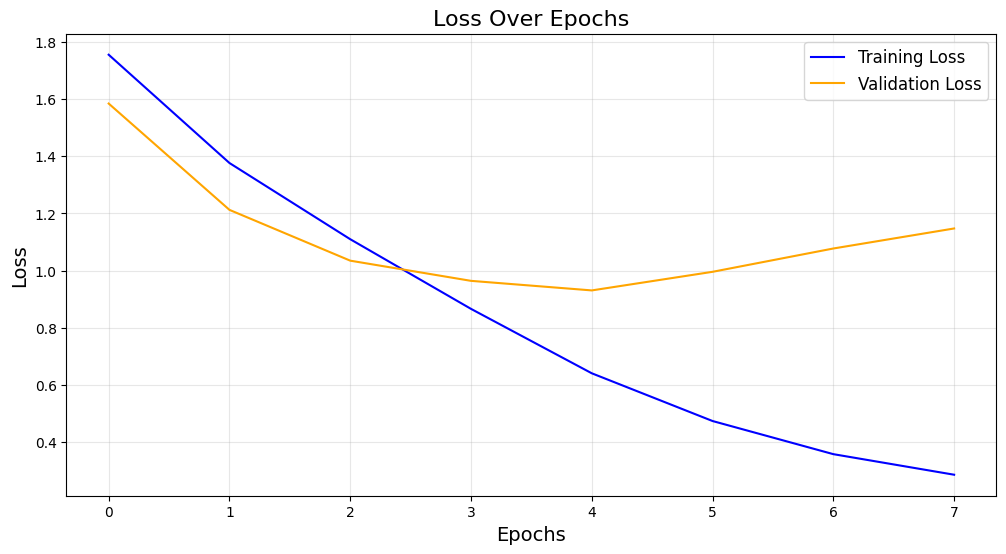

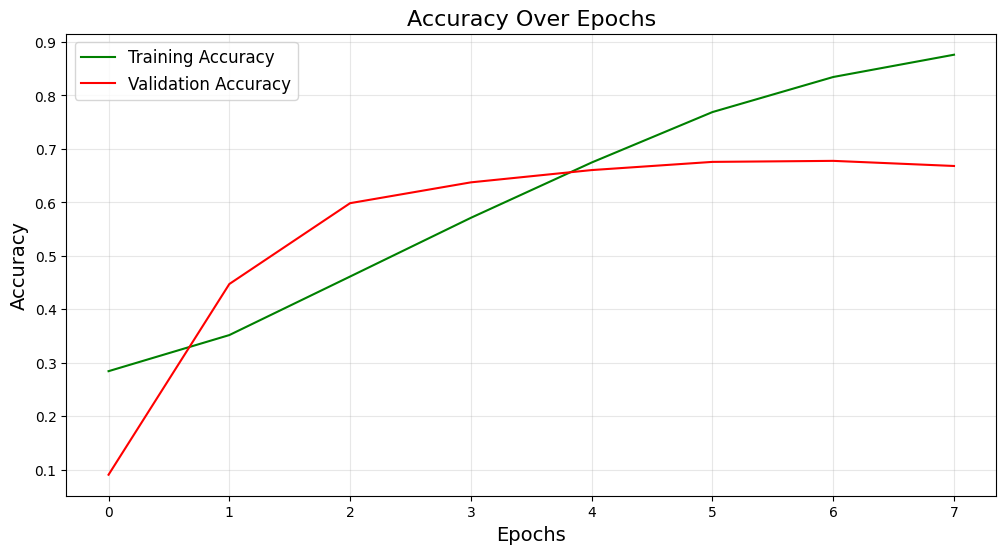

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()


In [ ]:
y_val_pred_prob = model.predict(X_val)  
y_val_pred = np.argmax(y_val_pred_prob, axis=1)  
y_val_true = np.argmax(y_val_categorical, axis=1)

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred))
macro_f1 = f1_score(y_val_true, y_val_pred, average='macro')
print(f"Macro F1-Score: {macro_f1:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.84      0.79      1057
           1       0.47      0.33      0.39       253
           2       0.23      0.04      0.07       126
           3       0.33      0.42      0.37       131

    accuracy                           0.66      1567
   macro avg       0.44      0.41      0.40      1567
weighted avg       0.62      0.66      0.63      1567

Macro F1-Score: 0.4037


**Frequency BoW FFNN**

In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),  
    y=labels  
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class weights: {class_weights_dict}")
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_val)

Class weights: {0: 0.37411618574431493, 1: 1.486522399392559, 2: 2.9935015290519877, 3: 3.122408293460925}


In [ ]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(frequency_bow_array.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')  
])

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.3601 - loss: 1.7343 - val_accuracy: 0.6745 - val_loss: 0.9773
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6340 - loss: 1.0120 - val_accuracy: 0.6745 - val_loss: 0.9870
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6981 - loss: 0.8391 - val_accuracy: 0.6796 - val_loss: 0.9662
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7564 - loss: 0.6690 - val_accuracy: 0.6886 - val_loss: 1.0471
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8093 - loss: 0.5383 - val_accuracy: 0.6841 - val_loss: 1.1262
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8551 - loss: 0.4108 - val_accuracy: 0.6854 - val_loss: 1.2203
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


In [ ]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


Training Loss: 0.5149
Training Accuracy: 0.8143
Validation Loss: 0.9662
Validation Accuracy: 0.6796


In [ ]:
y_val_pred_prob = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)
y_val_true = np.argmax(y_val, axis=1)

print("\nClassification Report:")
print(classification_report(y_val_true, y_val_pred))

macro_f1 = f1_score(y_val_true, y_val_pred, average='macro')
print(f"\nMacro F1-Score: {macro_f1:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.99      0.81      1057
           1       0.51      0.08      0.13       253
           2       0.00      0.00      0.00       126
           3       0.00      0.00      0.00       131

    accuracy                           0.68      1567
   macro avg       0.30      0.27      0.24      1567
weighted avg       0.54      0.68      0.57      1567


Macro F1-Score: 0.2352


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


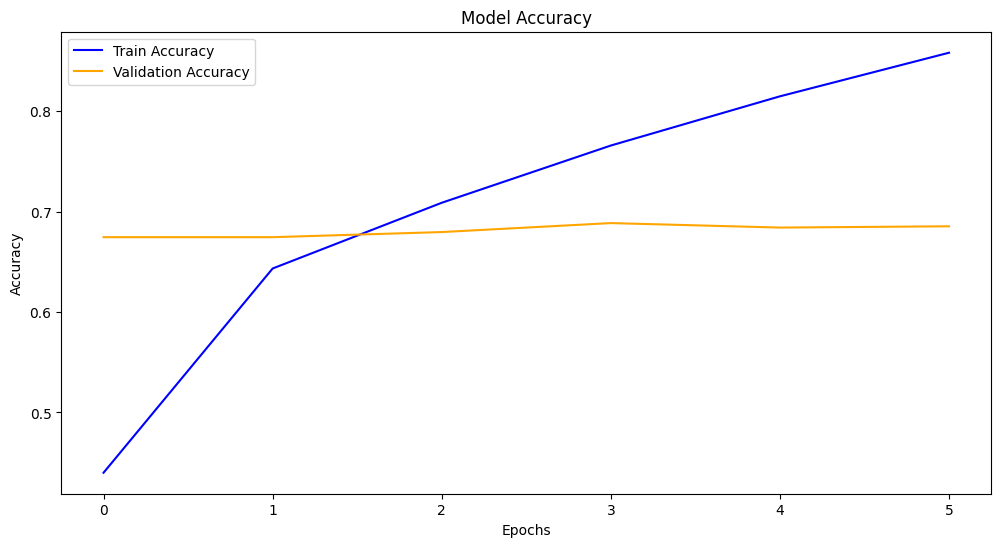

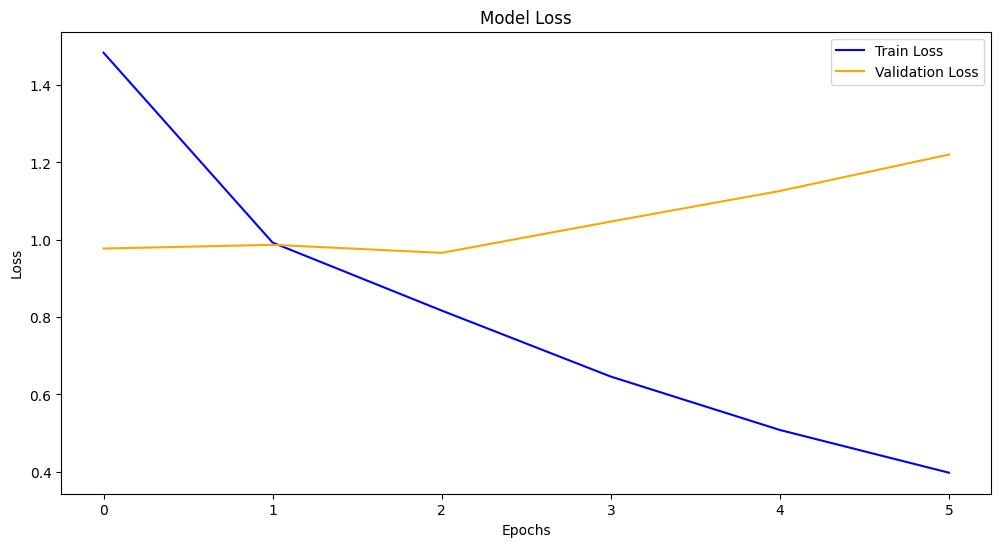

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**TF-IDF FFNN**

In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),  
    y=labels  
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class weights: {class_weights_dict}")

Class weights: {0: 0.37411618574431493, 1: 1.486522399392559, 2: 2.9935015290519877, 3: 3.122408293460925}


In [ ]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(tfidf_array.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')  
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weights_dict,  
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - accuracy: 0.2712 - loss: 1.9353 - val_accuracy: 0.1615 - val_loss: 1.8877
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3303 - loss: 1.4643 - val_accuracy: 0.4844 - val_loss: 1.2401
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4381 - loss: 1.2280 - val_accuracy: 0.6624 - val_loss: 0.9805
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5858 - loss: 0.8435 - val_accuracy: 0.6535 - val_loss: 0.9023
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7191 - loss: 0.5589 - val_accuracy: 0.6573 - val_loss: 0.9426
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8318 - loss: 0.3702 - val_accuracy: 0.6720 - val_loss: 1.0431
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8767 - loss: 0.2534 - val_accuracy: 0.6675 - val_loss: 1.1396
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


In [ ]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")



Training Loss: 0.3677
Training Accuracy: 0.9229
Validation Loss: 0.9023
Validation Accuracy: 0.6535


In [ ]:
y_val_pred_prob = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)
y_val_true = np.argmax(y_val, axis=1)

print("\nClassification Report:")
print(classification_report(y_val_true, y_val_pred))

macro_f1 = f1_score(y_val_true, y_val_pred, average='macro')
print(f"\nMacro F1-Score: {macro_f1:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.86      0.78      1057
           1       0.41      0.34      0.37       253
           2       0.12      0.02      0.03       126
           3       0.35      0.25      0.29       131

    accuracy                           0.65      1567
   macro avg       0.40      0.36      0.37      1567
weighted avg       0.59      0.65      0.62      1567


Macro F1-Score: 0.3689


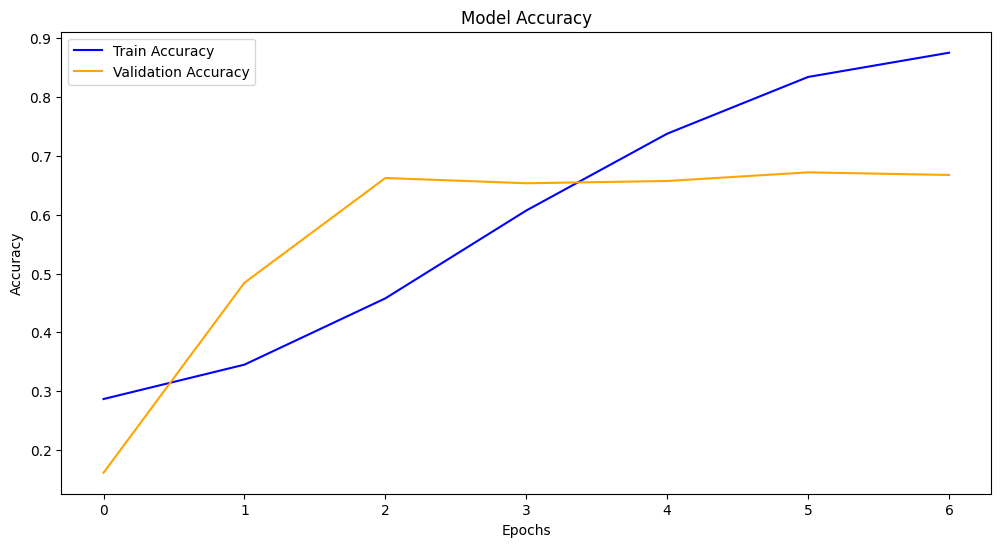

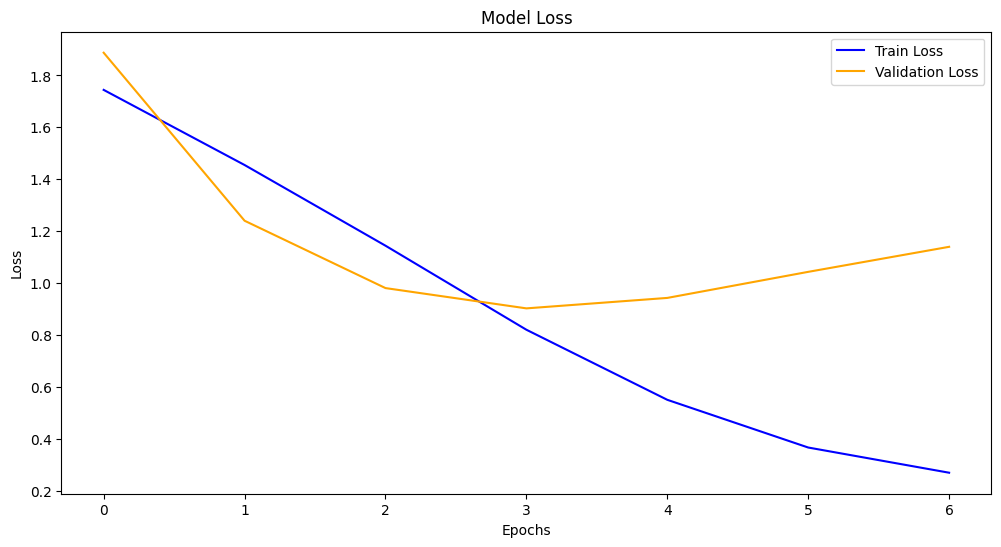

In [ ]:
# # Plot training & validation accuracy 
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Arabic Word embedding using MARBERTv2 FFNN**


In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),  
    y=labels  
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class weights: {class_weights_dict}")

Class weights: {0: 0.37411618574431493, 1: 1.486522399392559, 2: 2.9935015290519877, 3: 3.122408293460925}


In [ ]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.2832 - loss: 1.9513 - val_accuracy: 0.2227 - val_loss: 1.5351
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.2759 - loss: 1.6482 - val_accuracy: 0.2023 - val_loss: 1.5193
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2818 - loss: 1.4924 - val_accuracy: 0.2125 - val_loss: 1.4500
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2808 - loss: 1.4001 - val_accuracy: 0.2534 - val_loss: 1.3835
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2865 - loss: 1.3897 - val_accuracy: 0.2827 - val_loss: 1.3648
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2985 - loss: 1.3335 - val_accuracy: 0.3261 - val_loss: 1.3406
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2994 - loss: 1.3830 - val_accuracy: 0.2770 - val_loss: 1.3616
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2931 - loss: 1.3418 - val_accuracy: 

In [ ]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


Training Loss: 1.3048
Training Accuracy: 0.4013
Validation Loss: 1.3259
Validation Accuracy: 0.3669


In [ ]:
y_val_pred_prob = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)
y_val_true = np.argmax(y_val, axis=1)

print("\nClassification Report:")
print(classification_report(y_val_true, y_val_pred))

macro_f1 = f1_score(y_val_true, y_val_pred, average='macro')
print(f"\nMacro F1-Score: {macro_f1:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.40      0.52      1057
           1       0.25      0.13      0.18       253
           2       0.14      0.57      0.22       126
           3       0.13      0.33      0.18       131

    accuracy                           0.37      1567
   macro avg       0.32      0.36      0.28      1567
weighted avg       0.57      0.37      0.41      1567


Macro F1-Score: 0.2760


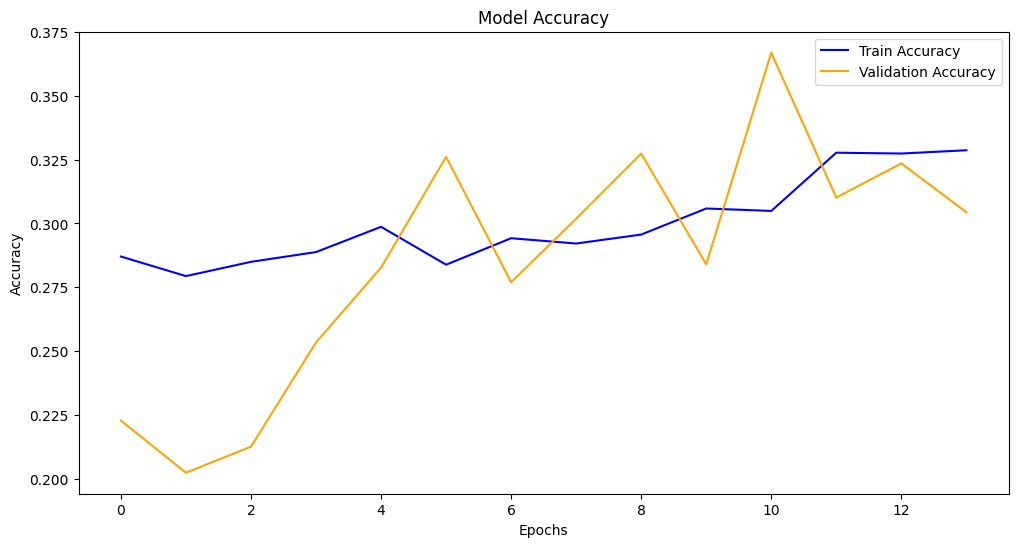

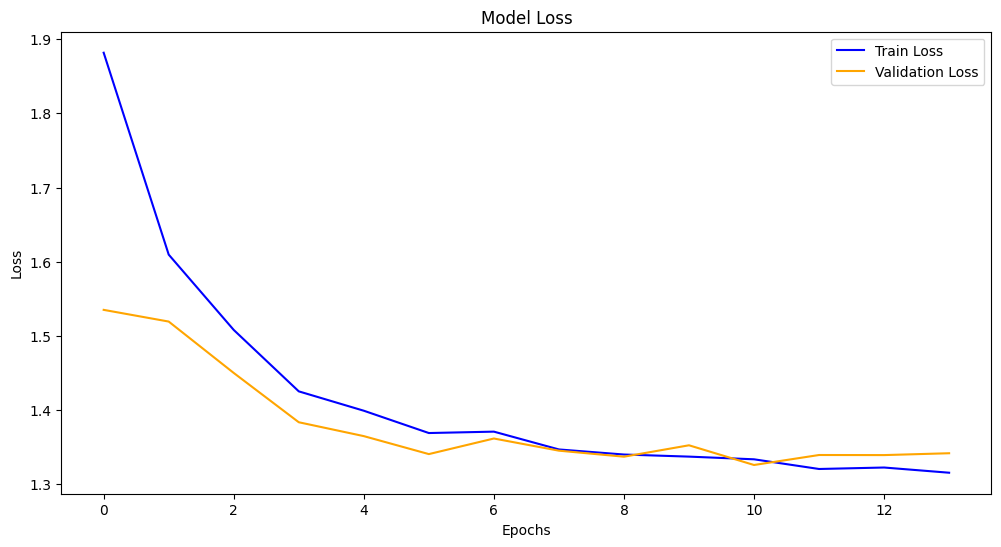

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5. Use LSTM NN

**Binary BOW LSTM**

In [ ]:
X_train = np.expand_dims(X_train, axis=1)
X_val = np.expand_dims(X_val, axis=1)

In [ ]:
print(X_train.shape)  
print(X_val.shape)

(6264, 1, 29024)
(1567, 1, 29024)


In [ ]:
model = Sequential([
    Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True,verbose=1)

In [ ]:
history = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_val, y_val_categorical),
    epochs=20,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.3595 - loss: 1.3904 - val_accuracy: 0.1429 - val_loss: 1.4040
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.4726 - loss: 1.1620 - val_accuracy: 0.5788 - val_loss: 1.0689
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.6724 - loss: 0.6942 - val_accuracy: 0.5673 - val_loss: 1.1417
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.7917 - loss: 0.4077 - val_accuracy: 0.5578 - val_loss: 1.4532
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8792 - loss: 0.2643 - val_accuracy: 0.5692 - val_loss: 1.5360
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [ ]:
train_loss, train_accuracy = model.evaluate(X_train, y_train_categorical)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7985 - loss: 0.8027
Training Loss: 0.8108
Training Accuracy: 0.7885


In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val_categorical)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5610 - loss: 1.0761
Validation Loss: 1.0689
Validation Accuracy: 0.5788


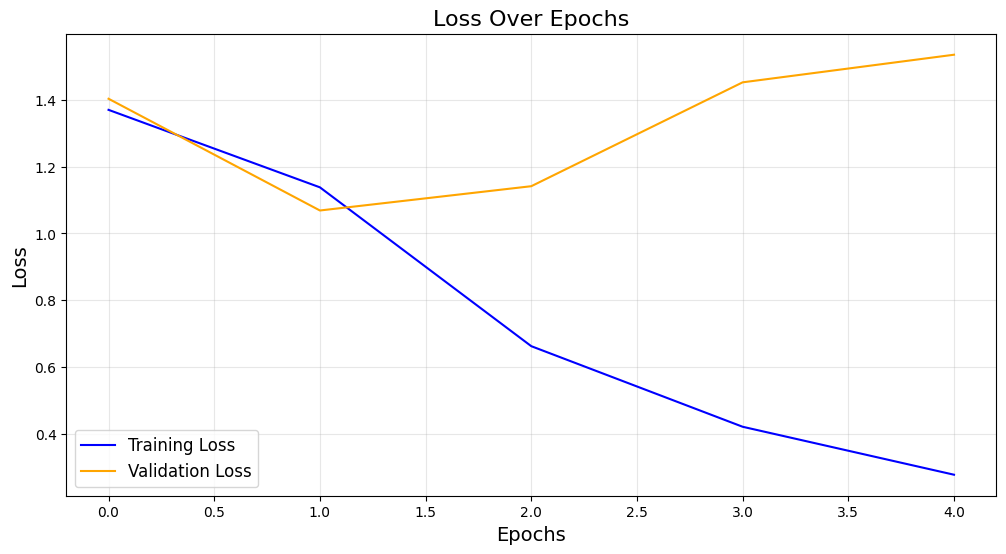

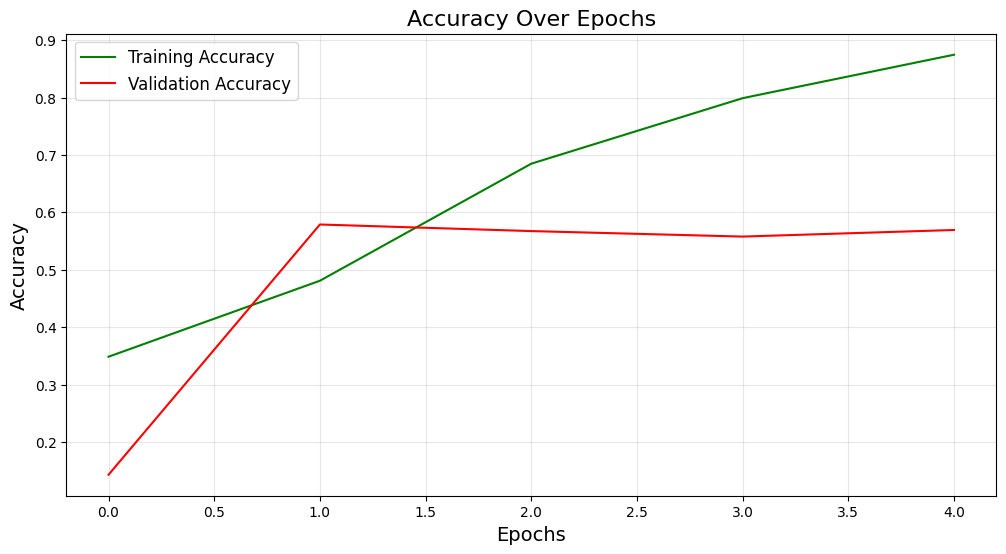

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [ ]:
y_val_pred_prob = model.predict(X_val)  
y_val_pred = np.argmax(y_val_pred_prob, axis=1)  
y_val_true = np.argmax(y_val_categorical, axis=1)

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred))

macro_f1 = f1_score(y_val_true, y_val_pred, average='macro')
print(f"Macro F1-Score: {macro_f1:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.68      0.72      1057
           1       0.31      0.49      0.38       253
           2       0.22      0.11      0.15       126
           3       0.29      0.36      0.32       131

    accuracy                           0.58      1567
   macro avg       0.40      0.41      0.39      1567
weighted avg       0.61      0.58      0.59      1567

Macro F1-Score: 0.3931


**Frequency BoW LSTM**

In [ ]:
X_train = np.expand_dims(X_train, axis=1)
X_val = np.expand_dims(X_val, axis=1)

In [ ]:
print(X_train.shape)  
print(X_val.shape)

(6264, 1, 29024)
(1567, 1, 29024)


In [ ]:
model = Sequential([
    Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True,verbose=1)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 65ms/step - accuracy: 0.4072 - loss: 1.3581 - val_accuracy: 0.1238 - val_loss: 1.4274
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.5409 - loss: 1.1546 - val_accuracy: 0.5948 - val_loss: 1.0666
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.7035 - loss: 0.7450 - val_accuracy: 0.5712 - val_loss: 1.1148
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8219 - loss: 0.4139 - val_accuracy: 0.5546 - val_loss: 1.4424
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8825 - loss: 0.2511 - val_accuracy: 0.5616 - val_loss: 1.5665
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [ ]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8284 - loss: 0.7717
Training Loss: 0.7762
Training Accuracy: 0.8265


In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5819 - loss: 1.0707
Validation Loss: 1.0666
Validation Accuracy: 0.5948


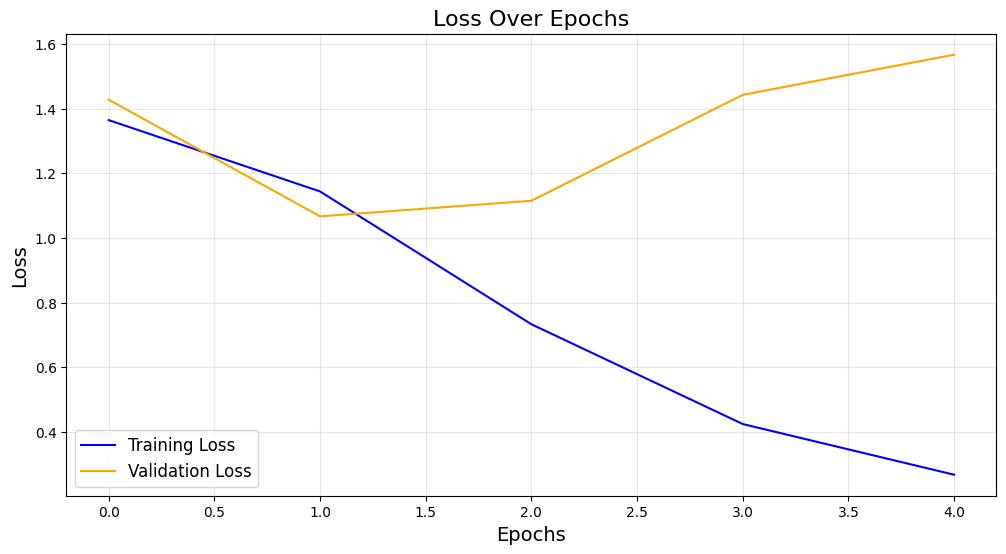

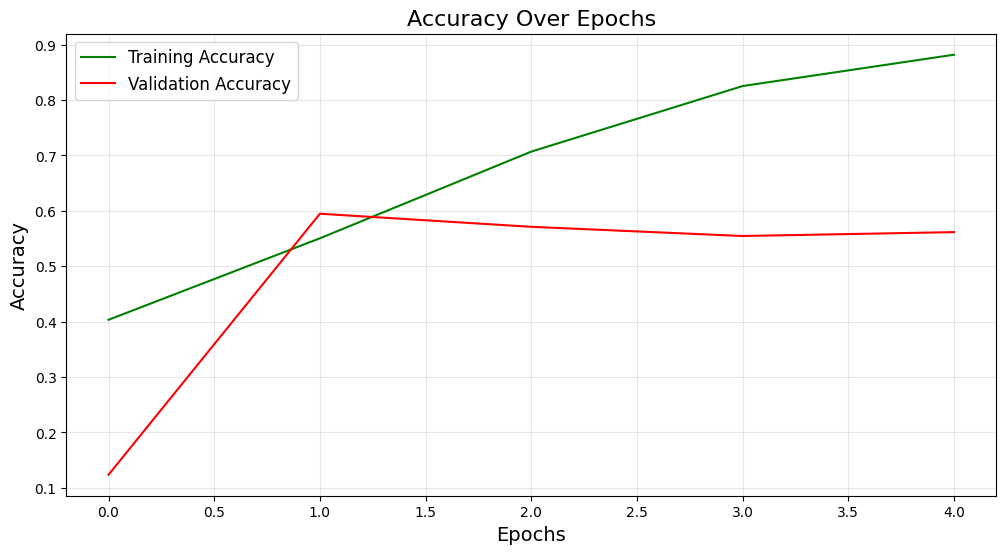

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [ ]:
y_val_pred_prob = model.predict(X_val) 
y_val_pred = np.argmax(y_val_pred_prob, axis=1)  
y_val_true = np.argmax(y_val, axis=1)

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred))
macro_f1 = f1_score(y_val_true, y_val_pred, average='macro')
print(f"Macro F1-Score: {macro_f1:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74      1057
           1       0.33      0.51      0.40       253
           2       0.36      0.06      0.11       126
           3       0.24      0.31      0.27       131

    accuracy                           0.59      1567
   macro avg       0.43      0.40      0.38      1567
weighted avg       0.62      0.59      0.60      1567

Macro F1-Score: 0.3796


**TF-IDF LSTM**

In [ ]:
X_train = np.expand_dims(X_train, axis=1)
X_val = np.expand_dims(X_val, axis=1)

In [ ]:
print(X_train.shape)  
print(X_val.shape)

(6264, 1, 29024)
(1567, 1, 29024)


In [ ]:
model = Sequential([
    Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True,verbose=1)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.2965 - loss: 1.3521 - val_accuracy: 0.0881 - val_loss: 1.4272
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5029 - loss: 1.0051 - val_accuracy: 0.5986 - val_loss: 1.1476
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.7085 - loss: 0.6664 - val_accuracy: 0.6126 - val_loss: 0.9849
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8382 - loss: 0.3612 - val_accuracy: 0.5960 - val_loss: 1.3868
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8983 - loss: 0.2350 - val_accuracy: 0.5558 - val_loss: 1.5386
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9282 - loss: 0.1723 - val_accuracy: 0.5795 - val_loss: 1.5714
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


In [ ]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9067 - loss: 0.3111
Training Loss: 0.3099
Training Accuracy: 0.9061


In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6090 - loss: 0.9829
Validation Loss: 0.9849
Validation Accuracy: 0.6126


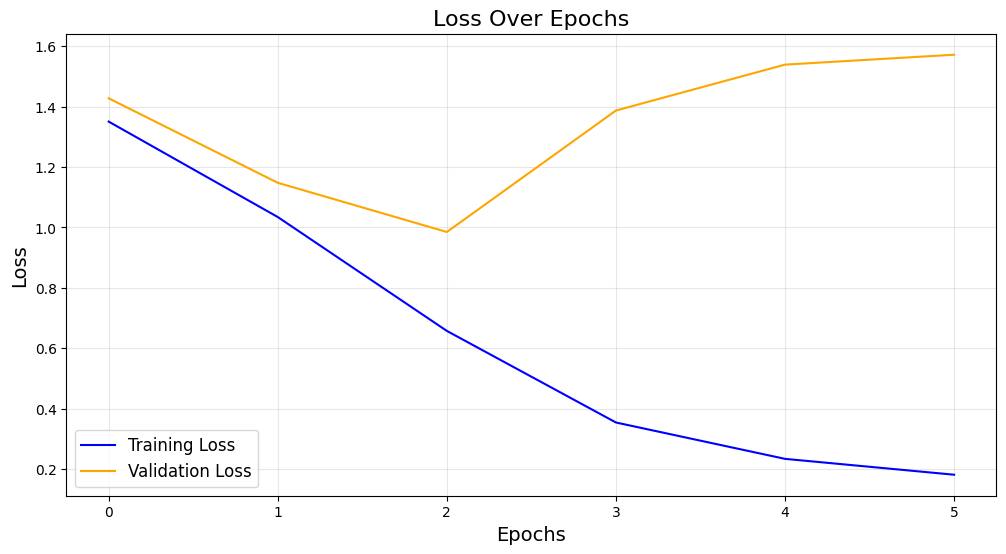

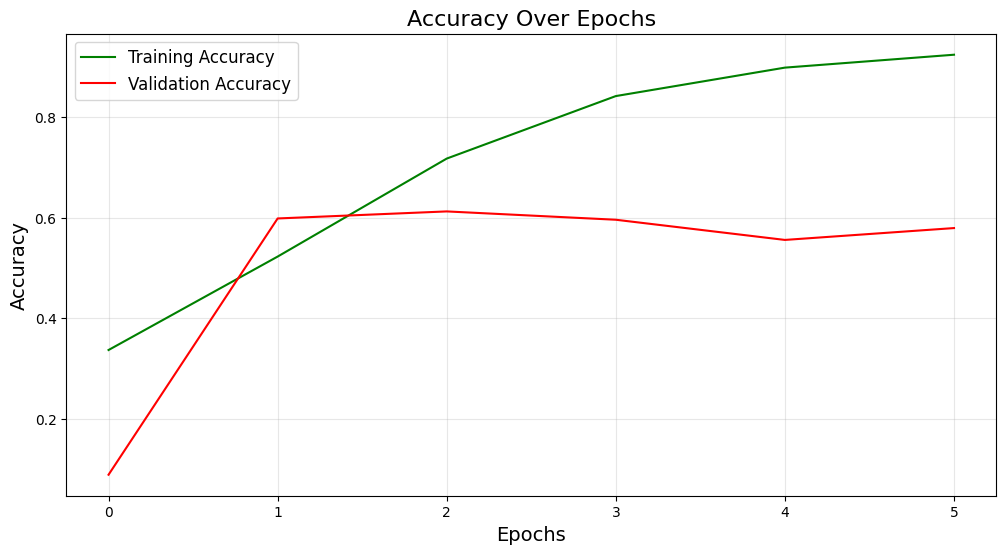

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [ ]:
y_val_pred_prob = model.predict(X_val) 
y_val_pred = np.argmax(y_val_pred_prob, axis=1)  
y_val_true = np.argmax(y_val, axis=1)

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred))

macro_f1 = f1_score(y_val_true, y_val_pred, average='macro')
print(f"Macro F1-Score: {macro_f1:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1057
           1       0.34      0.39      0.37       253
           2       0.11      0.09      0.10       126
           3       0.36      0.27      0.31       131

    accuracy                           0.61      1567
   macro avg       0.39      0.38      0.38      1567
weighted avg       0.60      0.61      0.61      1567

Macro F1-Score: 0.3844


**Arabic Word embedding using MARBERTv2 LSTM**

In [ ]:
X_train = np.expand_dims(X_train, axis=1)
X_val = np.expand_dims(X_val, axis=1)

In [ ]:
print(X_train.shape)  
print(X_val.shape)

(6264, 1, 256)
(1567, 1, 256)


In [ ]:
model = Sequential([
    Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True,verbose=1)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.1319 - loss: 1.4100 - val_accuracy: 0.2929 - val_loss: 1.3795
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.1827 - loss: 1.3638 - val_accuracy: 0.2521 - val_loss: 1.3401
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2442 - loss: 1.3417 - val_accuracy: 0.2444 - val_loss: 1.3873
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3064 - loss: 1.3601 - val_accuracy: 0.3050 - val_loss: 1.3765
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3507 - loss: 1.3405 - val_accuracy: 0.3516 - val_loss: 1.3835
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [ ]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2543 - loss: 1.3390
Training Loss: 1.3373
Training Accuracy: 0.2601


In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2457 - loss: 1.3446
Validation Loss: 1.3401
Validation Accuracy: 0.2521


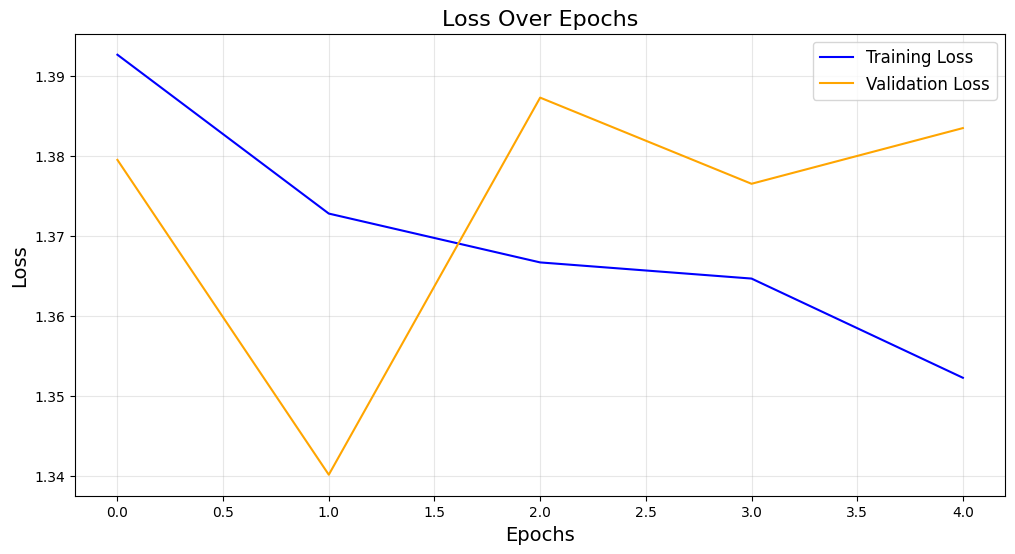

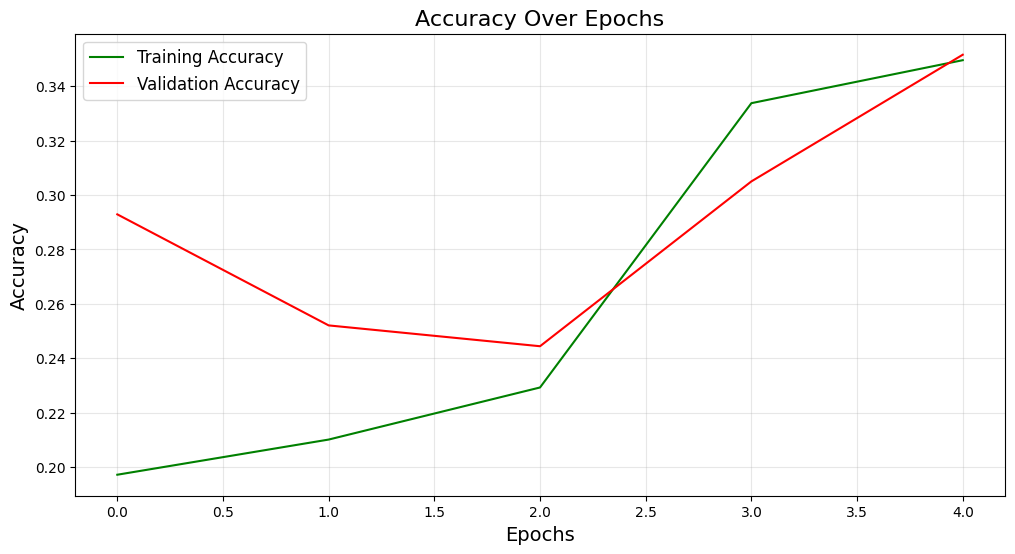

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [ ]:
y_val_pred_prob = model.predict(X_val)  
y_val_pred = np.argmax(y_val_pred_prob, axis=1)  
y_val_true = np.argmax(y_val, axis=1)

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred))

macro_f1 = f1_score(y_val_true, y_val_pred, average='macro')
print(f"Macro F1-Score: {macro_f1:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.21      0.33      1057
           1       0.18      0.21      0.19       253
           2       0.14      0.44      0.21       126
           3       0.11      0.47      0.18       131

    accuracy                           0.25      1567
   macro avg       0.29      0.33      0.23      1567
weighted avg       0.55      0.25      0.29      1567

Macro F1-Score: 0.2282


## 6. Show a comparison Table for Training and Validation Accuracy as follows 
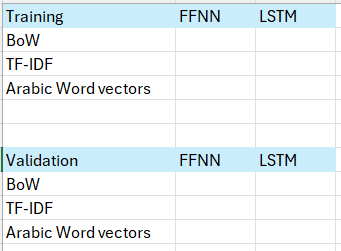

### Training
|               | FFNN  | LSTM  |
|---------------|-------|-------|
| BBoW          | 0.92  | 0.78  |
| FBoW          | 0.81  | 0.82  |
| TF-IDF        | 0.92  | 0.90  |
| Arabic Word   | 0.40  | 0.26  |

### Validation
|               | FFNN  | LSTM  |
|---------------|-------|-------|
| BBoW          | 0.66  | 0.57  |
| FBoW          | 0.67  | 0.59  |
| TF-IDF        | 0.65  | 0.61  |
| Arabic Word   | 0.36  | 0.25  |


### Model Performance Analysis

### Training Performance:

- **BBoW (Bag of Words)**: The best performing feature representation on the training set for both FFNN with 0.92 and LSTM with 0.78.
- **FBoW**: Slightly worse than BBoW for FFNN at 0.81 but better for LSTM at 0.82, suggesting that the LSTM model might be better suited to this feature type.
- **TF-IDF**: Performs similarly to BBoW for FFNN, 0.92, whereas for LSTM, it performs pretty well at 0.90. Hence, TF-IDF might be capturing more informative features for LSTM.
- **Arabic Word Embeddings**: This perform much worse on both models-FFNN does 0.40 and LSTM only 0.26 on training data. This suggests that may Arabic embeddings are not contributing meaningfully to the model's understanding for this particular task.

### Validation Performance:

- **BBoW**: Still does well on the validation set, with FFNN at 0.66 and LSTM at 0.57, though showing a significant drop from the train performance and might indicate overfitting.
- **FBoW** has a slight decrease in performance, with the values of 0.67 and 0.59 for FFNN and LSTM, respectively, though it overfits a little because its performance was pretty close to that of BBoW.
- **TF-IDF**: Performs reasonably well. The performance decrease on the validation set is there, but it is still competitive: FFNN at 0.65, LSTM at 0.61.
- **Arabic Word Embeddings**: Arabic word embeddings show consistently low performance in the validation set, as in the training set. That may well indicate that they are unsuitable for current task or dataset.

### Important Notes:
- **BBoW and TF-IDF** work best for the task, while for the LSTM model, **TF-IDF** is doing a bit better.
- **Arabic Word Embeddings** perform considerably worse, which may indicate that they are not suitable for task or dataset.
- There seems to be immense **overfitting** in particular for BBoW and TF-IDF, as the performance on the training set is far better compared to the validation set.

***In all of the above tasks , you have full flexibility to use any hyperparameters , splits , ..etc no restrictions***

## Competition Model
In this section you;re free to use any model that would give you the best accuracy , either a model studied in the course or any other Model you like . What is forbidden is to use any external data 
The final evaluation will be on the **Private** not **Public** Leader boards

### Fine-Tuning MarBERTv2 for Arabic Tweet Sentiment Classification

####  Loading the MarBERTv2 Model

In [ ]:
model_name = "UBC-NLP/MARBERTv2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

#### Unfreeze all layers of the model


In [ ]:
for param in model.parameters():
    param.requires_grad = True

#### Tokenization

In [ ]:
tokenized_data = tokenizer(
    df["Translated_Cleaned_Tweet"].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)
labels = torch.tensor(df["label"].tolist())

#### Data Splitting

In [ ]:
input_ids = tokenized_data["input_ids"]
attention_mask = tokenized_data["attention_mask"]

train_input_ids, val_input_ids, train_attention_mask, val_attention_mask, train_labels, val_labels = train_test_split(
    input_ids,
    attention_mask,
    labels,
    test_size=0.15,
    random_state=42
)

In [ ]:
train_encodings = {
    "input_ids": train_input_ids,
    "attention_mask": train_attention_mask
}
val_encodings = {
    "input_ids": val_input_ids,
    "attention_mask": val_attention_mask
}

#### Creating a Custom Dataset

In [ ]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["label"] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

####  Trainer Configuration & Fine-Tuning the Model

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,

)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

#### Model Evaluation

In [ ]:
trainer.train()
label_mapping = {"OBJ": 0, "NEG": 1, "NEUTRAL": 2, "POS": 3}
predictions = trainer.predict(val_dataset)
y_preds = np.array(predictions.predictions.argmax(-1))
val_labels_numpy = val_labels.numpy()
print(classification_report(val_labels_numpy, y_preds, target_names=label_mapping.keys()))
macro_f1 = f1_score(val_labels_numpy, y_preds, average="macro")
print(f"Macro F1-Score: {macro_f1:.4f}")

tokenizer_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-3-a94ececfdeb3>:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val

Epoch,Training Loss,Validation Loss
1,No log,0.638900
2,0.775900,0.646509
3,0.535300,0.679157


<ipython-input-3-a94ececfdeb3>:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-3-a94ececfdeb3>:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["label"] = torch.tensor(self.labels[idx])
<ipython-input-3-a94ececfdeb3>:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-3-a94ececfdeb3>:64: UserWarning: To copy construct from a tensor, it is recommended to 

              precision    recall  f1-score   support

         OBJ       0.87      0.85      0.86       799
         NEG       0.58      0.70      0.63       184
     NEUTRAL       0.44      0.39      0.41       101
         POS       0.62      0.60      0.61        91

    accuracy                           0.77      1175
   macro avg       0.63      0.63      0.63      1175
weighted avg       0.77      0.77      0.77      1175

Macro F1-Score: 0.6293


#### Save Models 

In [ ]:
saved_model= model.save_pretrained('MARBERTv2_model')
saved_tokenizer = tokenizer.save_pretrained('MARBERTv2_tokenizer')

### Clean Test Dataset

In [ ]:
df = pd.read_csv("test_data.csv")
df.head()

,Tweet_ID,Tweet
0,1000,سعوديون يطالبون الجيش المصري باختراع علاج لكور...
1,1001,النضافة ،النظام،الراحة و الحرية اللي بيحس بيها...
2,1002,عرض الاسبوع 36 ألف متابع #وش_أكثر_شي_يسهرك #صي...
3,1003,خمس الاف #الامارات #الهلال #النصر #السعودية #ا...
4,1004,حمزاوي: لابد من إقالة وزير الداخلية ومدير أمن ...


In [ ]:
df["Cleaned_Tweet"] = df["Tweet"].apply(clean_text)

In [ ]:
df[["Tweet","Cleaned_Tweet"]].head()

,Tweet,Cleaned_Tweet
0,سعوديون يطالبون الجيش المصري باختراع علاج لكور...,سعوديون يطالبون الجيش المصري باختراع علاج لكور...
1,النضافة ،النظام،الراحة و الحرية اللي بيحس بيها...,النضافه النظامالراحه و الحريه اللي بيحس بيها ا...
2,عرض الاسبوع 36 ألف متابع #وش_أكثر_شي_يسهرك #صي...,عرض الاسبوع ٣٦ الف متابع وش اكثر شي يسهرك صيام...
3,خمس الاف #الامارات #الهلال #النصر #السعودية #ا...,خمس الاف الامارات الهلال النصر السعوديه الكويت...
4,حمزاوي: لابد من إقالة وزير الداخلية ومدير أمن ...,حمزاوي لابد من اقاله وزير الداخليه ومدير امن ب...


In [ ]:
df["Translated_Cleaned_Tweet"] = df["Cleaned_Tweet"].apply(translate_english_to_arabic)

In [ ]:
df[["Cleaned_Tweet","Translated_Cleaned_Tweet"]].head(10)

,Cleaned_Tweet,Translated_Cleaned_Tweet
0,سعوديون يطالبون الجيش المصري باختراع علاج لكور...,سعوديون يطالبون الجيش المصري باختراع علاج لكور...
1,النضافه النظامالراحه و الحريه اللي بيحس بيها ا...,النضافه النظامالراحه و الحريه اللي بيحس بيها ا...
2,عرض الاسبوع ٣٦ الف متابع وش اكثر شي يسهرك صيام...,عرض الاسبوع ٣٦ الف متابع وش اكثر شي يسهرك صيام...
3,خمس الاف الامارات الهلال النصر السعوديه الكويت...,خمس الاف الامارات الهلال النصر السعوديه الكويت...
4,حمزاوي لابد من اقاله وزير الداخليه ومدير امن ب...,حمزاوي لابد من اقاله وزير الداخليه ومدير امن ب...
5,غلطت م الاول رنا سماحه,غلطت م الاول رنا سماحه
6,و انما دغل يعج بالنبت علي اختلاف اشكاله والاخت...,و انما دغل يعج بالنبت علي اختلاف اشكاله والاخت...
7,ياباسم عصام سلطان بيسال عليك وبيقول انت فين من...,ياباسم عصام سلطان بيسال عليك وبيقول انت فين من...
8,لتحميل كتاب تغريد في السعاده والتفاؤل والامل ل...,لتحميل كتاب تغريد في السعاده والتفاؤل والامل ل...
9,غير صحيح وموقفي الرافض سجل في اكثر من مقال بجر...,غير صحيح وموقفي الرافض سجل في اكثر من مقال بجر...


In [ ]:
df.to_csv("clean_test_data.csv", index=False)

In [ ]:
test = pd.read_csv("clean_test_data.csv")

In [ ]:
test.head()

,Tweet_ID,Tweet,Cleaned_Tweet,Translated_Cleaned_Tweet
0,1000,سعوديون يطالبون الجيش المصري باختراع علاج لكور...,سعوديون يطالبون الجيش المصري باختراع علاج لكور...,سعوديون يطالبون الجيش المصري باختراع علاج لكور...
1,1001,النضافة ،النظام،الراحة و الحرية اللي بيحس بيها...,النضافه النظامالراحه و الحريه اللي بيحس بيها ا...,النضافه النظامالراحه و الحريه اللي بيحس بيها ا...
2,1002,عرض الاسبوع 36 ألف متابع #وش_أكثر_شي_يسهرك #صي...,عرض الاسبوع ٣٦ الف متابع وش اكثر شي يسهرك صيام...,عرض الاسبوع ٣٦ الف متابع وش اكثر شي يسهرك صيام...
3,1003,خمس الاف #الامارات #الهلال #النصر #السعودية #ا...,خمس الاف الامارات الهلال النصر السعوديه الكويت...,خمس الاف الامارات الهلال النصر السعوديه الكويت...
4,1004,حمزاوي: لابد من إقالة وزير الداخلية ومدير أمن ...,حمزاوي لابد من اقاله وزير الداخليه ومدير امن ب...,حمزاوي لابد من اقاله وزير الداخليه ومدير امن ب...


#### Load Saved Models 

In [ ]:
saved_model = AutoModelForSequenceClassification.from_pretrained('MARBERTv2_model')
saved_tokenizer = AutoTokenizer.from_pretrained('MARBERTv2_tokenizer')

In [ ]:
test_df = pd.read_csv("clean_test_data.csv")

####  Tokenizing the Test Data

In [ ]:
test_tokenized_data = saved_tokenizer(
    test_df["Tweet"].tolist(),  
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

test_encodings = {
    "input_ids": test_tokenized_data["input_ids"],
    "attention_mask": test_tokenized_data["attention_mask"]
}

In [ ]:
class TextDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

test_dataset = TextDataset(test_encodings)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="no",  
    save_strategy="epoch",
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=saved_model,
    args=training_args,
)

#### Predictions

In [ ]:
predictions = trainer.predict(test_dataset)
y_preds = np.array(predictions.predictions.argmax(-1))

In [ ]:
dfout = pd.DataFrame(list(zip(test_df["Tweet_ID"], y_preds)), columns=['Tweet_ID', 'Label'])
dfout.to_csv("test_predictions.csv", index=False)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-7-2637f50192af>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [ ]:
dfout.head()

,Tweet_ID,Label
0,1000,0
1,1001,2
2,1002,0
3,1003,0
4,1004,0


#### Submission File Creation

In [ ]:
label_mapping = {0: "OBJ", 1: "NEG", 2: "NEUTRAL", 3: "POS"}
dfout = pd.DataFrame(list(zip(test_df["Tweet_ID"], y_preds)), columns=['Tweet_ID', 'Predicted_Label'])

dfout['Predicted_Label'] = [label_mapping[label] for label in y_preds]
dfout.columns = ['Tweet_ID', 'Label']

dfout.to_csv("submission.csv", index=False)

In [ ]:
dfout.head()

,Tweet_ID,Label
0,1000,OBJ
1,1001,NEUTRAL
2,1002,OBJ
3,1003,OBJ
4,1004,OBJ


### The End of the notebook

### To submit predictions to Kaggle competition you need to follow those steps :

In [ ]:
# Model Prediction here 
# The model should be able to reproduce y_pred that you submitted to the competition
y_pred = #prediction  from any model you want

##### now we are ready to construct the submission file based on the above predictions . The following cell constructs the output submission dataframe dfout (already provided to you ). y_pred in the cell is a generic dataframe that can be replaced by any of the above predictions or any new model #####

In [ ]:
y_pred # Will be a binary array of predictions 

In [48]:
# Trying a Random submission 
import numpy as np
import random
y_pred=np.random.randint(0,4,2000)
# Mapping dictionary
label_mapping = {
    0: "POS",
    1: "NEG",
    2: "NEUTRAL",
    3: "OBJ"
}
y_pred=[label_mapping[label] for label in y_pred]


In [19]:
import pandas as pd
df_test = pd.read_csv('E:\\Kaggle 2024-2025\\test_data.csv')

In [21]:
df_test.head()

,Tweet_ID,Tweet
0,1000,سعوديون يطالبون الجيش المصري باختراع علاج لكور...
1,1001,النضافة ،النظام،الراحة و الحرية اللي بيحس بيها...
2,1002,عرض الاسبوع 36 ألف متابع #وش_أكثر_شي_يسهرك #صي...
3,1003,خمس الاف #الامارات #الهلال #النصر #السعودية #ا...
4,1004,حمزاوي: لابد من إقالة وزير الداخلية ومدير أمن ...


In [50]:
# 3. construct the output data frame exactly like this 
dfout = pd.DataFrame(list(zip(df_test.Tweet_ID,y_pred)),columns=['Tweet_ID','Label'])

## dfout.shape

##### the next cell writes dfout to a csv file that can be submitted to the kaggle competition 
##### You can try developing a submission file for each of the predictions in the above models , and submit it one by one to check performance
##### The file name <font color='red'>submission_Tweets.csv</font>  is totally optional , you can use any name , but know which file you're uploading to the competition 

In [56]:
dfout.to_csv("submission_Tweets.csv",index=False) # inorder not to write the index

In [36]:
y_pred[0:10]

['POS', 'OBJ', 'NEUTRAL', 'POS', 'NEG', 'POS', 'POS', 'NEUTRAL', 'OBJ', 'NEG']

In [40]:
from sklearn.metrics import f1_score
df_gt = pd.read_csv('E:\\Kaggle 2024-2025\\sample_submission.csv')
y_true = df_gt['gold_label']


# Compute F1 score (macro-average for multi-class)
score = f1_score(y_true, y_pred, average='macro')
print(f"Macro F1 Score: {score:.4f}")


Macro F1 Score: 0.3211


## Instructions
- Due Date Jan19th. 2025
- You are not allowed to use any external dataset except those mentioned here
- You can use any AI model you want to submit to Kaggle 
- Your final ipynb file should be zipped and uploaded on Moodle before the due date
- Your Final ipynb file should be bug free , 
- The final submission file .csv you uploaded to Kaggle should be exactly reproducible from your notebook uploaded on Moodle


### Grading Rules out of 15%

- 0% : you didn't submit anything to Kaggle leaderboard , even if you made some tasks in the notebook
- 0% : **if you used any extrenal dataset other than the datasets on the Competition links**
- Between 0 and 10% will be graded on the coding activity in the Notebook .
- 10% : means that you successfully uploaded and ranked on Kaggle with any accuracy and ranking AND submitted the notebook (bug-free) and fully working .
- The remaining 5% will be based on the **private** leaderboard rank .
